In [1]:
#import library
import warnings
warnings.filterwarnings('ignore')
import sys
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
%matplotlib inline
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

In [2]:
#List all environment id in gym openAI
for i in gym.envs.registry.all():
    print(i.id)

CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v1
Acrobot-v1
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v3
BipedalWalkerHardcore-v3
CarRacing-v1
Blackjack-v1
FrozenLake-v1
FrozenLake8x8-v1
CliffWalking-v0
Taxi-v3
Reacher-v2
Pusher-v2
InvertedPendulum-v2
InvertedDoublePendulum-v2
HalfCheetah-v2
HalfCheetah-v3
Hopper-v2
Hopper-v3
Swimmer-v2
Swimmer-v3
Walker2d-v2
Walker2d-v3
Ant-v2
Ant-v3
Humanoid-v2
Humanoid-v3
HumanoidStandup-v2


# MountainCar-v0

## Specify the Environment, and Explore the State and Action Spaces 

In [3]:
#create an environment and set random seed
env = gym.make('MountainCar-v0')
env.seed(505)
print(env)

<TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>


c:\users\bayu\opencv\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [4]:
#explore state observation space
print('State space: ', env.observation_space)
print('- low: ', env.observation_space.low)
print('- high: ', env.observation_space.high)

State space:  Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
- low:  [-1.2  -0.07]
- high:  [0.6  0.07]


In [5]:
#generate some samples from the state space 
print('State space samples: ')
print(np.array([env.observation_space.sample() for i in range(10)]))

State space samples: 
[[-0.14097683  0.00273538]
 [-0.16550872 -0.04418056]
 [ 0.00738715  0.00929341]
 [-0.0531082  -0.06650735]
 [-0.49164233 -0.04358518]
 [-0.3632702   0.06724533]
 [-0.67919695  0.00541531]
 [-0.11560813  0.00928956]
 [ 0.5356243  -0.03057246]
 [-0.22542867  0.01326921]]


In [6]:
#explore the action space
print('Action space: ', env.action_space)

#generate some samples from the action space
print('Action space samples: ')
print(np.array([env.action_space.sample() for i in range(10)]))

Action space:  Discrete(3)
Action space samples: 
[2 0 0 1 2 1 2 0 1 1]


## Discretize the State Space with a Uniform Grid

In [7]:
#define a uniformly-spaced grid that can be used to discretize a space
def create_uniform_grid(low, high, bins = (10, 10)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] for dim in range(len(bins))]
    print('Uniform grid: [<low>, <high>] / <bins> => <splits>')
    
    for l, h, b, splits in zip(low, high, bins, grid):
        print('    [{}, {}] / {} => {}'.format(l, h, b, splits))
    return grid

#generate create uniform grid function
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]


[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

In [8]:
#define function for discretize a sample as per given grid
def discretize(sample, grid):
    return list(int(np.digitize(s, g)) for s, g in zip(sample, grid)) 


#test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [[-1.0 , -5.0],
     [-0.81, -4.1],
     [-0.8 , -4.0],
     [-0.5 ,  0.0],
     [ 0.2 , -1.9],
     [ 0.8 ,  4.0],
     [ 0.81,  4.1],
     [ 1.0 ,  5.0]])
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print('\nSamples: ', repr(samples), sep = '\n')
print('\nDiscretized samples: ', repr(discretized_samples), sep = '\n')

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.0, 1.0] / 10 => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]

Samples: 
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples: 
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


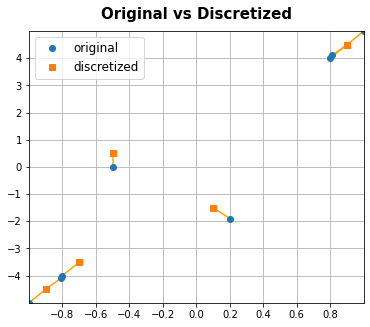

In [9]:
#define function for visualize original and discretized samples on a given 2-dimensional grid
def visualize_samples(samples, discretized_samples, grid, low = None, high = None):
    fig, ax = plt.subplots(figsize = (6, 5))
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)
    
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    grid_extended = np.hstack((np.array([low]).T, grid, np.array([high]).T))  
    grid_centers = (grid_extended[:, 1:] + grid_extended[:, :-1]) / 2  
    locs = np.stack(grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))).T  

    ax.plot(samples[:, 0], samples[:, 1], 'o')  
    ax.plot(locs[:, 0], locs[:, 1], 's')  
    ax.add_collection(mc.LineCollection(list(zip(samples, locs)), colors = 'orange'))
    ax.set_title('Original vs Discretized', fontsize = 15, pad = 12, fontweight = 'bold')
    ax.legend(['original', 'discretized'], fontsize = 12)

#generate function of visualize original and discretized samples on a given 2-dimensional grid
visualize_samples(samples, discretized_samples, grid, low, high)

In [10]:
#create a grid to discretize the state space
state_grid = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins = (10, 10))
print(state_grid)

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 10 => [-1.02000004 -0.84000003 -0.66000003 -0.48000002 -0.30000001 -0.12
  0.06        0.24000001  0.42000002]
    [-0.07000000029802322, 0.07000000029802322] / 10 => [-0.056 -0.042 -0.028 -0.014  0.     0.014  0.028  0.042  0.056]
[array([-1.02000004, -0.84000003, -0.66000003, -0.48000002, -0.30000001,
       -0.12      ,  0.06      ,  0.24000001,  0.42000002]), array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,
        0.056])]


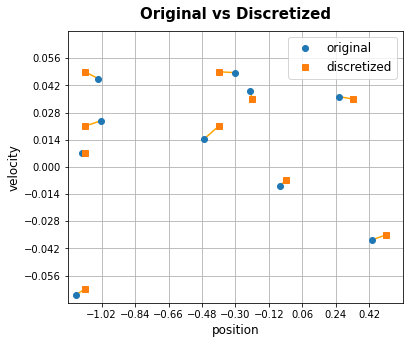

In [11]:
#obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.observation_space.sample() for i in range(10)])
discretized_state_samples = np.array([discretize(sample, state_grid) for sample in state_samples])
visualize_samples(state_samples, discretized_state_samples, state_grid, env.observation_space.low, env.observation_space.high)
plt.title('Original vs Discretized', fontsize = 15, pad = 12, fontweight = 'bold')
plt.xlabel('position', fontsize = 12)
plt.ylabel('velocity', fontsize = 12)
plt.show()

## Q-Learning

In [12]:
#define function class Q-learning agent
class QLearningAgent:
    def __init__(self, env, state_grid, alpha = 0.02, gamma = 0.99, epsilon = 1.0, epsilon_decay_rate = 0.9995, 
                 min_epsilon = .01, seed = 505):
        self.env = env
        self.state_grid = state_grid
        self.state_size = tuple(len(splits) + 1 for splits in self.state_grid)  
        self.action_size = self.env.action_space.n  
        self.seed = np.random.seed(seed)
        print('Environment: ', self.env)
        print('State space size: ', self.state_size)
        print('Action space size:', self.action_size)
        
        #learning parameters
        self.alpha = alpha  
        self.gamma = gamma 
        self.epsilon = self.initial_epsilon = epsilon  
        self.epsilon_decay_rate = epsilon_decay_rate 
        self.min_epsilon = min_epsilon
        
        #create Q-table
        self.q_table = np.zeros(shape=(self.state_size + (self.action_size,)))
        print("Q table size:", self.q_table.shape)

    def preprocess_state(self, state):
        # TODO: implement this
        return tuple(discretize(state, self.state_grid))

    def reset_episode(self, state):
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)

        #cecide initial action
        self.last_state = self.preprocess_state(state)
        self.last_action = np.argmax(self.q_table[self.last_state])
        return self.last_action
    
    def reset_exploration(self, epsilon = None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward = None, done = None, mode = 'train'):
        state = self.preprocess_state(state)
        if mode == 'test':
            #test mode: simply produce an action
            action = np.argmax(self.q_table[state])
        else:
            #train mode (default): update Q table, pick next action
            self.q_table[self.last_state + (self.last_action,)] += self.alpha * \
                (reward + self.gamma * max(self.q_table[state]) - self.q_table[self.last_state + (self.last_action,)])

            #exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                #pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                #pick the best action from Q table
                action = np.argmax(self.q_table[state])

        #roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

#generate function of Q-learning agent    
q_agent = QLearningAgent(env, state_grid)

Environment:  <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size:  (10, 10)
Action space size: 3
Q table size: (10, 10, 3)


In [13]:
#define function for run agent in given reinforcement learning environment and return scores
def run(agent, env, num_episodes = 5000, mode = 'train'):
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes + 1):
        #initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        #roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        #save final score
        scores.append(total_reward)
        
        #print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print('\rEpisode {}/{} | Max Average Score: {}'.format(i_episode, num_episodes, max_avg_score), end = '')
                sys.stdout.flush()
    return scores

#generate run agent function
scores = run(q_agent, env)

Episode 5000/5000 | Max Average Score: -167.84

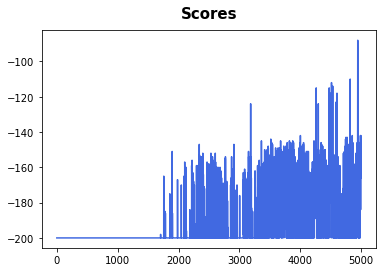

In [14]:
#plotting scores obtained per episode
plt.plot(scores, color = 'royalblue') 
plt.title('Scores', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

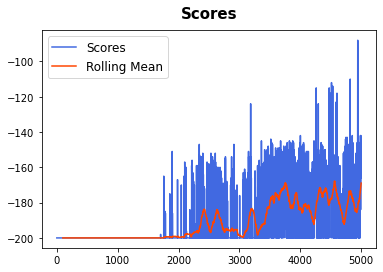

In [15]:
#define function for plotting scores and optional rolling mean using specified window
def plot_scores(scores, rolling_window = 100):
    plt.plot(scores, color = 'royalblue') 
    plt.title('Scores', fontsize = 15, pad = 12, fontweight = 'bold')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean, color = 'orangered')
    plt.legend(['Scores', 'Rolling Mean'], fontsize = 12)
    return rolling_mean

#generate function of plot scores
rolling_mean = plot_scores(scores)

[TEST] Completed 100 episodes with avg. score = -159.83


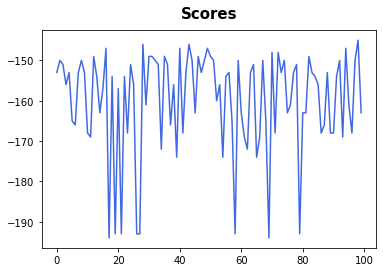

In [16]:
#run in test mode and analyze scores obtained
test_scores = run(q_agent, env, num_episodes = 100, mode = 'test')
print('[TEST] Completed {} episodes with avg. score = {}'.format(len(test_scores), np.mean(test_scores)))
plt.plot(test_scores, color = 'royalblue') 
plt.title('Scores', fontsize = 15, pad = 12, fontweight = 'bold')
plt.show()

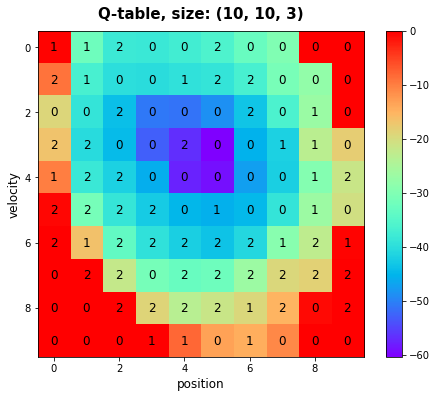

In [17]:
#define function for visualize max Q-value for each state and corresponding action
def plot_q_table(q_table):
    q_image = np.max(q_table, axis = 2)       
    q_actions = np.argmax(q_table, axis = 2) 

    fig, ax = plt.subplots(figsize = (8, 6))
    cax = ax.imshow(q_image, cmap = 'rainbow');
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color = 'black', horizontalalignment = 'center', verticalalignment = 'center', 
                    fontsize = 12)
    ax.grid(False)
    ax.set_title('Q-table, size: {}'.format(q_table.shape), fontsize = 15, pad = 12, fontweight = 'bold')
    ax.set_xlabel('position', fontsize = 12)
    ax.set_ylabel('velocity', fontsize = 12)

#generate function of plotting Q-table
plot_q_table(q_agent.q_table)

## Modify the grid

In [18]:
#TODO: create a new agent with a different state space grid
state_grid_new = create_uniform_grid(env.observation_space.low, env.observation_space.high, bins = (20, 20))
q_agent_new = QLearningAgent(env, state_grid_new)
q_agent_new.scores = [] 

Uniform grid: [<low>, <high>] / <bins> => <splits>
    [-1.2000000476837158, 0.6000000238418579] / 20 => [-1.11000004 -1.02000004 -0.93000004 -0.84000003 -0.75000003 -0.66000003
 -0.57000002 -0.48000002 -0.39000002 -0.30000001 -0.21000001 -0.12
 -0.03        0.06        0.15000001  0.24000001  0.33000001  0.42000002
  0.51000002]
    [-0.07000000029802322, 0.07000000029802322] / 20 => [-0.063 -0.056 -0.049 -0.042 -0.035 -0.028 -0.021 -0.014 -0.007  0.
  0.007  0.014  0.021  0.028  0.035  0.042  0.049  0.056  0.063]
Environment:  <TimeLimit<OrderEnforcing<MountainCarEnv<MountainCar-v0>>>>
State space size:  (20, 20)
Action space size: 3
Q table size: (20, 20, 3)


Episode 10000/10000 | Max Average Score: -157.5

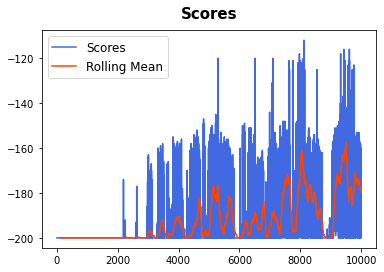

In [19]:
#train it over a desired number of episodes and analyze scores
q_agent_new.scores += run(q_agent_new, env, num_episodes = 10000) 
rolling_mean_new = plot_scores(q_agent_new.scores)

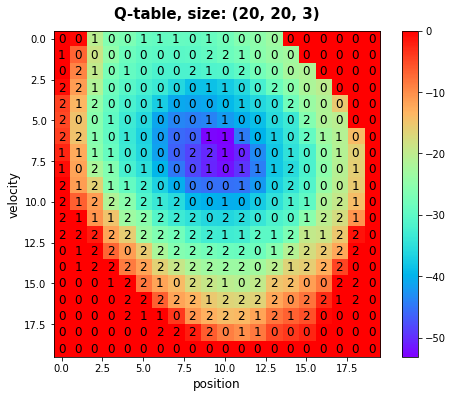

In [20]:
#visualize the learned Q-table
plot_q_table(q_agent_new.q_table)

In [21]:
#check smart agent
state = env.reset()
score = 0
for t in range(200):
    action = q_agent_new.act(state, mode = 'test')
    env.render()
    state, reward, done, _ = env.step(action)
    score += reward
        
print('Final score:', score)
env.close()

Final score: -200.0


# Acrobat-v0

## Specify the Environment, and Explore the State and Action Spaces

In [22]:
#create an environment and set random seed
env = gym.make('Acrobot-v1')
env.seed(505)
print(env)

<TimeLimit<OrderEnforcing<AcrobotEnv<Acrobot-v1>>>>


c:\users\bayu\opencv\lib\site-packages\gym\core.py:172: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  deprecation(


In [23]:
#explore state (observation) space
print('State space: ', env.observation_space)
print('- low: ', env.observation_space.low)
print('- high: ', env.observation_space.high)

#explore action space
print('Action space: ', env.action_space)

State space:  Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
- low:  [ -1.        -1.        -1.        -1.       -12.566371 -28.274334]
- high:  [ 1.        1.        1.        1.       12.566371 28.274334]
Action space:  Discrete(3)


## Tiling

In [24]:
#define function for a uniformly-spaced grid that can be used for tile-coding a space
def create_tiling_grid(low, high, bins = (10, 10), offsets = (0.0, 0.0)):
    grid = [np.linspace(low[dim], high[dim], bins[dim] + 1)[1:-1] + offsets[dim] for dim in range(len(bins))]
    print('Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>')
    
    for l, h, b, o, splits in zip(low, high, bins, offsets, grid):
        print('    [{}, {}] / {} + ({}) => {}'.format(l, h, b, o, splits))
    return grid

#generate function of tile-coding space
low = [-1.0, -5.0]
high = [1.0, 5.0]
create_tiling_grid(low, high, bins = (10, 10), offsets = (-0.1, 0.5)) 

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.1) => [-0.9 -0.7 -0.5 -0.3 -0.1  0.1  0.3  0.5  0.7]
    [-5.0, 5.0] / 10 + (0.5) => [-3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5]


[array([-0.9, -0.7, -0.5, -0.3, -0.1,  0.1,  0.3,  0.5,  0.7]),
 array([-3.5, -2.5, -1.5, -0.5,  0.5,  1.5,  2.5,  3.5,  4.5])]

In [25]:
#define function for multiple tilings using the provided specifications
def create_tilings(low, high, tiling_specs):
    return [create_tiling_grid(low, high, bins, offsets) for bins, offsets in tiling_specs]


#tiling specs: [(<bins>, <offsets>), ...]
tiling_specs = [((10, 10), (-0.066, -0.33)),
                ((10, 10), (0.0, 0.0)),
                ((10, 10), (0.066, 0.33))]
tilings = create_tilings(low, high, tiling_specs)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]


<AxesSubplot:title={'center':'Tilings'}>

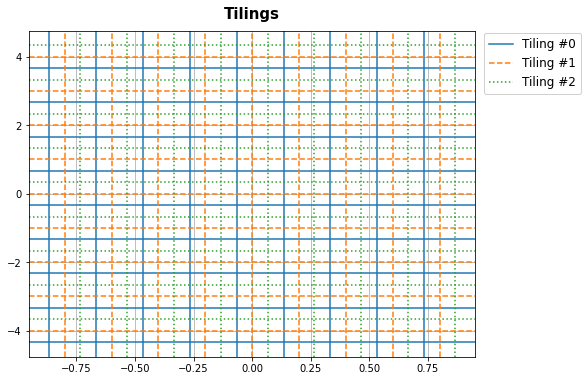

In [26]:
#define function for plotting each tiling as a grid
def visualize_tilings(tilings):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    linestyles = ['-', '--', ':']
    legend_lines = []

    fig, ax = plt.subplots(figsize = (8, 6))
    for i, grid in enumerate(tilings):
        for x in grid[0]:
            l = ax.axvline(x = x, color = colors[i % len(colors)], linestyle = linestyles[i % len(linestyles)], label = i)
        for y in grid[1]:
            l = ax.axhline(y = y, color = colors[i % len(colors)], linestyle = linestyles[i % len(linestyles)])
        legend_lines.append(l)
    ax.grid('off')
    ax.legend(legend_lines, ['Tiling #{}'.format(t) for t in range(len(legend_lines))], facecolor = 'white', framealpha = 0.9,
             fontsize = 12, loc = 'right', bbox_to_anchor = (1.25, 0.9))
    ax.set_title('Tilings', fontsize = 15, pad = 12, fontweight = 'bold')
    return ax 

#generate function of 
visualize_tilings(tilings)

## Tile Encoding 

In [27]:
#define function for discretize a sample as per given grid
def discretize(sample, grid):
    return tuple(int(np.digitize(s, g)) for s, g in zip(sample, grid))  # apply along each dimension

#define function for encode given sample using tile-coding
def tile_encode(sample, tilings, flatten = False):
    encoded_sample = [discretize(sample, grid) for grid in tilings]
    return np.concatenate(encoded_sample) if flatten else encoded_sample


#test with some sample values
samples = [(-1.2 , -5.1 ),
           (-0.75,  3.25),
           (-0.5 ,  0.0 ),
           ( 0.25, -1.9 ),
           ( 0.15, -1.75),
           ( 0.75,  2.5 ),
           ( 0.7 , -3.7 ),
           ( 1.0 ,  5.0 )]
encoded_samples = [tile_encode(sample, tilings) for sample in samples]
print('Samples: ', repr(samples), sep = '\n')
print('\nEncoded samples: ', repr(encoded_samples), sep = '\n')

Samples: 
[(-1.2, -5.1), (-0.75, 3.25), (-0.5, 0.0), (0.25, -1.9), (0.15, -1.75), (0.75, 2.5), (0.7, -3.7), (1.0, 5.0)]

Encoded samples: 
[[(0, 0), (0, 0), (0, 0)], [(1, 8), (1, 8), (0, 7)], [(2, 5), (2, 5), (2, 4)], [(6, 3), (6, 3), (5, 2)], [(6, 3), (5, 3), (5, 2)], [(9, 7), (8, 7), (8, 7)], [(8, 1), (8, 1), (8, 0)], [(9, 9), (9, 9), (9, 9)]]


<AxesSubplot:title={'center':'Tile-encoded samples'}>

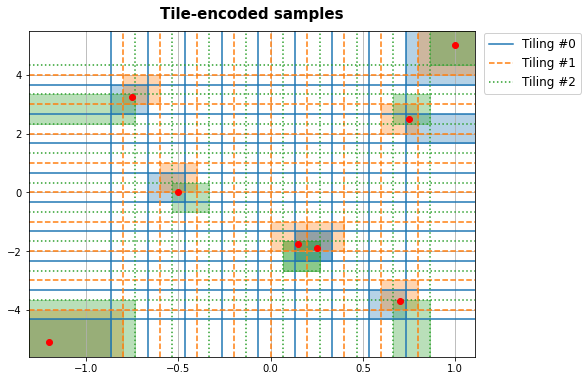

In [28]:
#define function for visualize samples by activating the respective tiles
def visualize_encoded_samples(samples, encoded_samples, tilings, low = None, high = None):
    samples = np.array(samples)  

    #show tiling grids
    ax = visualize_tilings(tilings)
    
    #if bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        #pre-render (invisible) samples to automatically set reasonable axis limits, and use them as (low, high)
        ax.plot(samples[:, 0], samples[:, 1], 'o', alpha = 0.0)
        low = [ax.get_xlim()[0], ax.get_ylim()[0]]
        high = [ax.get_xlim()[1], ax.get_ylim()[1]]

    #map each encoded sample (which is really a list of indices) to the corresponding tiles it belongs to
    tilings_extended = [np.hstack((np.array([low]).T, grid, np.array([high]).T)) for grid in tilings]  
    tile_centers = [(grid_extended[:, 1:] + grid_extended[:, :-1]) / 2 for grid_extended in tilings_extended]  
    tile_toplefts = [grid_extended[:, :-1] for grid_extended in tilings_extended]  
    tile_bottomrights = [grid_extended[:, 1:] for grid_extended in tilings_extended]  

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    for sample, encoded_sample in zip(samples, encoded_samples):
        for i, tile in enumerate(encoded_sample):
            #shade the entire tile with a rectangle
            topleft = tile_toplefts[i][0][tile[0]], tile_toplefts[i][1][tile[1]]
            bottomright = tile_bottomrights[i][0][tile[0]], tile_bottomrights[i][1][tile[1]]
            ax.add_patch(Rectangle(topleft, bottomright[0] - topleft[0], bottomright[1] - topleft[1], color = colors[i], 
                                   alpha = 0.33))

            #in case sample is outside tile bounds, it may not have been highlighted properly
            if any(sample < topleft) or any(sample > bottomright):
                #so plot a point in the center of the tile and draw a connecting line
                cx, cy = tile_centers[i][0][tile[0]], tile_centers[i][1][tile[1]]
                ax.add_line(Line2D([sample[0], cx], [sample[1], cy], color = colors[i]))
                ax.plot(cx, cy, 's', color = colors[i])
    
    #finally, plot original samples
    ax.plot(samples[:, 0], samples[:, 1], 'o', color = 'r')

    ax.margins(x = 0, y = 0) 
    ax.set_title('Tile-encoded samples', fontsize = 15, pad = 12, fontweight = 'bold')
    return ax

visualize_encoded_samples(samples, encoded_samples, tilings)

## Q-Table with Tile Coding

In [29]:
#define class function for Simple Q-table
class QTable:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        #TODO: create Q-table, initialize all Q-values to zero
        self.q_table = np.zeros(shape = (self.state_size + (self.action_size,)))
        print('QTable(): size = ', self.q_table.shape)

#define class function for composite Q-table with an internal tile coding scheme
class TiledQTable:
    def __init__(self, low, high, tiling_specs, action_size):
        self.tilings = create_tilings(low, high, tiling_specs)
        self.state_sizes = [tuple(len(splits) + 1 for splits in tiling_grid) for tiling_grid in self.tilings]
        self.action_size = action_size
        self.q_tables = [QTable(state_size, self.action_size) for state_size in self.state_sizes]
        print('TiledQTable(): no. of internal tables = ', len(self.q_tables))
    
    def get(self, state, action):
        #TODO: encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        #TODO: retrieve q-value for each tiling, and return their average
        value = 0.0
        for idx, q_table in zip(encoded_state, self.q_tables):
            value += q_table.q_table[tuple(idx + (action,))]
        value /= len(self.q_tables)
        return value
    
    def update(self, state, action, value, alpha=0.1):
        #TODO: encode state to get tile indices
        encoded_state = tile_encode(state, self.tilings)
        
        #TODO: update q-value for each tiling by update factor alpha
        for idx, q_table in zip(encoded_state, self.q_tables):
            value_ = q_table.q_table[tuple(idx + (action,))]  # current value
            q_table.q_table[tuple(idx + (action,))] = alpha * value + (1.0 - alpha) * value_


#test with a sample Q-table
tq = TiledQTable(low, high, tiling_specs, 2)
s1 = 3
s2 = 4
a = 0
q = 1.0
print('[GET]    Q({}, {}) = {}'.format(samples[s1], a, tq.get(samples[s1], a))) 
print('[UPDATE] Q({}, {}) = {}'.format(samples[s2], a, q)); tq.update(samples[s2], a, q)  
print('[GET]    Q({}, {}) = {}'.format(samples[s1], a, tq.get(samples[s1], a)))  

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (-0.066) => [-0.866 -0.666 -0.466 -0.266 -0.066  0.134  0.334  0.534  0.734]
    [-5.0, 5.0] / 10 + (-0.33) => [-4.33 -3.33 -2.33 -1.33 -0.33  0.67  1.67  2.67  3.67]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.0) => [-0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8]
    [-5.0, 5.0] / 10 + (0.0) => [-4. -3. -2. -1.  0.  1.  2.  3.  4.]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 10 + (0.066) => [-0.734 -0.534 -0.334 -0.134  0.066  0.266  0.466  0.666  0.866]
    [-5.0, 5.0] / 10 + (0.33) => [-3.67 -2.67 -1.67 -0.67  0.33  1.33  2.33  3.33  4.33]
QTable(): size =  (10, 10, 2)
QTable(): size =  (10, 10, 2)
QTable(): size =  (10, 10, 2)
TiledQTable(): no. of internal tables =  3
[GET]    Q((0.25, -1.9), 0) = 0.0
[UPDATE] Q((0.15, -1.75), 0) = 1.0
[GET]    Q((0.25, -1.9), 0) = 0.06666666666666667


## Implement a Q-Learning Agent using Tile-Coding

In [30]:
#define class function for Q-Learning agent that can act on a continuous state space by discretizing
class QLearningAgent:
    def __init__(self, env, tq, alpha = 0.02, gamma = 0.99, epsilon = 1.0, epsilon_decay_rate = 0.9995, min_epsilon = .01, 
                 seed = 0):
        #environment info
        self.env = env
        self.tq = tq 
        self.state_sizes = tq.state_sizes           
        self.action_size = self.env.action_space.n  
        self.seed = np.random.seed(seed)
        print('Environment: ', self.env)
        print('State space sizes: ', self.state_sizes)
        print('Action space size: ', self.action_size)
        
        #learning parameters
        self.alpha = alpha  
        self.gamma = gamma  
        self.epsilon = self.initial_epsilon = epsilon  
        self.epsilon_decay_rate = epsilon_decay_rate  
        self.min_epsilon = min_epsilon

    def reset_episode(self, state):
        #gradually decrease exploration rate
        self.epsilon *= self.epsilon_decay_rate
        self.epsilon = max(self.epsilon, self.min_epsilon)
        
        self.last_state = state
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        self.last_action = np.argmax(Q_s)
        return self.last_action
    
    def reset_exploration(self, epsilon = None):
        self.epsilon = epsilon if epsilon is not None else self.initial_epsilon

    def act(self, state, reward = None, done = None, mode = 'train'):
        Q_s = [self.tq.get(state, action) for action in range(self.action_size)]
        #pick the best action from Q table
        greedy_action = np.argmax(Q_s)
        if mode == 'test':
            #test mode: simply produce an action
            action = greedy_action
        else:
            #train mode (default): update Q table, pick next action
            value = reward + self.gamma * max(Q_s)
            self.tq.update(self.last_state, self.last_action, value, self.alpha)

            #exploration vs. exploitation
            do_exploration = np.random.uniform(0, 1) < self.epsilon
            if do_exploration:
                #pick a random action
                action = np.random.randint(0, self.action_size)
            else:
                #pick the greedy action
                action = greedy_action

        #roll over current state, action for next step
        self.last_state = state
        self.last_action = action
        return action

#generate function of Q-learning
n_bins = 5
bins = tuple([n_bins] * env.observation_space.shape[0])
offset_pos = (env.observation_space.high - env.observation_space.low) / (3 * n_bins)

tiling_specs = [(bins, -offset_pos), (bins, tuple([0.0]*env.observation_space.shape[0])), (bins, offset_pos)]

tq = TiledQTable(env.observation_space.low, env.observation_space.high, tiling_specs, env.action_space.n)
agent = QLearningAgent(env, tq)

Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.73333334 -0.33333334  0.06666666  0.46666666]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.73333334 -0.33333334  0.06666666  0.46666666]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.73333334 -0.33333334  0.06666666  0.46666666]
    [-1.0, 1.0] / 5 + (-0.13333334028720856) => [-0.73333334 -0.33333334  0.06666666  0.46666666]
    [-12.566370964050293, 12.566370964050293] / 5 + (-1.675516128540039) => [-9.21533871 -4.18879032  0.83775806  5.86430645]
    [-28.274333953857422, 28.274333953857422] / 5 + (-3.769911289215088) => [-20.73451166  -9.42477808   1.8849555   13.19468908]
Tiling: [<low>, <high>] / <bins> + (<offset>) => <splits>
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-1.0, 1.0] / 5 + (0.0) => [-0.6 -0.2  0.2  0.6]
    [-12.566370964050293

In [31]:
#define function for run agent in given reinforcement learning environment and return scores
def run(agent, env, num_episodes = 5000, mode = 'train'):
    scores = []
    max_avg_score = -np.inf
    for i_episode in range(1, num_episodes + 1):
        #initialize episode
        state = env.reset()
        action = agent.reset_episode(state)
        total_reward = 0
        done = False

        #roll out steps until done
        while not done:
            state, reward, done, info = env.step(action)
            total_reward += reward
            action = agent.act(state, reward, done, mode)

        #save final score
        scores.append(total_reward)

        #print episode stats
        if mode == 'train':
            if len(scores) > 100:
                avg_score = np.mean(scores[-100:])
                if avg_score > max_avg_score:
                    max_avg_score = avg_score
            if i_episode % 100 == 0:
                print('\rEpisode {}/{} | Max Average Score: {}'.format(i_episode, num_episodes, max_avg_score), end = '')
                sys.stdout.flush()
    return scores

scores = run(agent, env)

Episode 5000/5000 | Max Average Score: -279.17

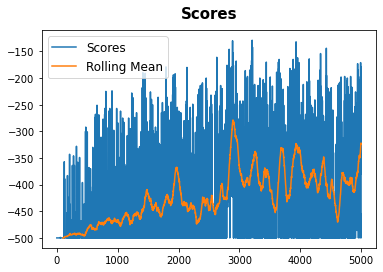

In [32]:
#define function for plotting scores and optional rolling mean using specified window
def plot_scores(scores, rolling_window=100):
    plt.plot(scores)
    plt.title('Scores', fontsize = 15, pad = 12, fontweight = 'bold')
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean)
    plt.legend(['Scores', 'Rolling Mean'], fontsize = 12)
    return rolling_mean

rolling_mean = plot_scores(scores)